# Extracting Data #

### PIP DOWNLOADS ###

In [1]:
!pip install opendatasets

In [2]:
!pip install -q datasets transformers

# !pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00


In [3]:
# For special loss functions

!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.1 MB/s eta 0:00:00


### Kaggle API ###

In [4]:
import opendatasets as od

In [5]:
# Kaggle API username and key: {"username":"meganrottkamp","key":"ed76fd6e08cc1d607845adb45d15a37f"}
# Kaggle Dataset: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/code?datasetId=1209633

# Downloading data using Kaggle API
od.download("https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/code?datasetId=1209633")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: meganrottkamp
Your Kaggle Key: ··········


100%|██████████| 195M/195M [00:02<00:00, 77.3MB/s]


The dataset contains 780 breast ultrasound images(PNG format). The data  was collected among 600 female patients in ages between 25 and 75 years old in 2018.

The dataset has 3 labels:
*   0 - Benign
*   1 - Malignant
*   2 - Normal

Each image also has an associated masked ground truth image.

### Importing Images ###

In [6]:
# Importing Libraries

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import re
import requests
import random


In [7]:
# Indexing Function

def num (image) :
    val = 0
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    return val

In [8]:
label2id = dict({
    'benign': 0,
    'malignant': 1,
    'normal': 2
})

id2label = {
    0: 'benign',
    1: 'malignant',
    2: 'normal'
}

print(id2label[0])
print(label2id['normal'])

benign
2


In [9]:
# separate the images into masked and unmasked
masked_images = glob.glob("/content/breast-ultrasound-images-dataset/*/*/*_mask*")
non_masked_images = [file for file in glob.glob(os.path.join("/content/breast-ultrasound-images-dataset/*/*", '*')) if 'mask' not in file]

id_list = []
img_list = []
mask_list = []
label_list = []

non_masked_images.sort()
masked_images.sort()

count = len(non_masked_images)
i = 0
desired_size = (256, 256)

while i < count:
    img = non_masked_images[i]
    image_name = img.split('/')[-1].split(')')[0] + ')'
    # ID
    id = str(image_name[0]) + str(num(image_name))
    # Label
    label = img.split('/')[-2]
    if label != 'normal':
        id_list.append(id)
        label_list.append(label2id[label])
        # Image
        image = cv2.imread(img, cv2.IMREAD_UNCHANGED)
        resized_img = cv2.resize(image, desired_size, interpolation = cv2.INTER_NEAREST)
        img_list.append(Image.fromarray(resized_img))
        # Mask
        r = re.compile(r".*"+re.escape(image_name)) # look for mask
        masks = list(filter(r.match, masked_images))
        mask = None
        for m in masks:
          if mask is None:
            mask =  cv2.imread(m)
          else:
            extr_mask = cv2.imread(m)
            mask = cv2.bitwise_or(mask, extr_mask)
        resized_mask = cv2.resize(mask, desired_size, interpolation = cv2.INTER_NEAREST)
        # print("last mask: ", np.unique(resized_mask))
        mask_list.append((Image.fromarray(resized_mask)).convert('I'))
        # masked_images = masked_images[len(masks):]

    i += 1

In [ ]:
# Benign, 437 samples
# Normal, 133 samples
# Malignant, 210 samples

### Create Image Dataset ###

In [10]:
from datasets import Dataset, Image

def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

In [11]:
dataset = create_dataset(images = img_list, labels = mask_list)
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 647
})

In [12]:
dataset[5]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': <PIL.TiffImagePlugin.TiffImageFile image mode=I size=256x256>}

In [13]:
# from sklearn.preprocessing import Binarizer

image = dataset[5]["label"]

ground_truth_seg = np.array(image)
# ground_truth_seg = (np.where(ground_truth_seg > 0.5, 1, 0)).astype(np.int32)
# ground_truth_mask = np.array(item["label"].convert('1')).astype(np.int32)

print(ground_truth_seg)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
np.unique(ground_truth_seg)

array([  0, 255], dtype=int32)

In [15]:
# normalize to the range 0-1

# binary_mask = np.where(img_array > 128, 1, 0)
ground_truth_seg = (ground_truth_seg / 255).astype('int32')
np.unique(ground_truth_seg)

array([0, 1], dtype=int32)

(256, 256)


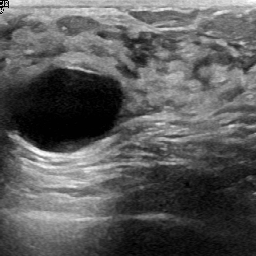

In [16]:
print(dataset[5]["image"].size)
dataset[5]["image"]

(256, 256)


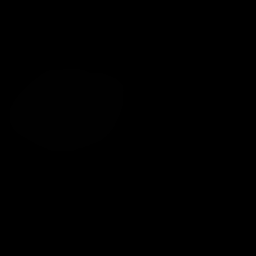

In [17]:
print(dataset[5]["label"].size)
dataset[5]["label"]

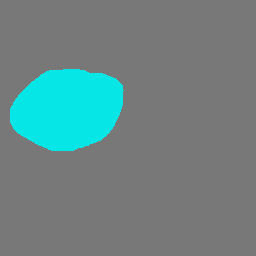

In [18]:
from PIL import Image

# a random color palette mapping each class to a color (RGB)
palette = [[120, 120, 120], [6, 230, 230]]

color_seg = np.zeros((ground_truth_seg.shape[0], ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3

for label, color in enumerate(palette):
    color_seg[ground_truth_seg == label, :] = color

Image.fromarray(color_seg)

### Visualizing Images ###

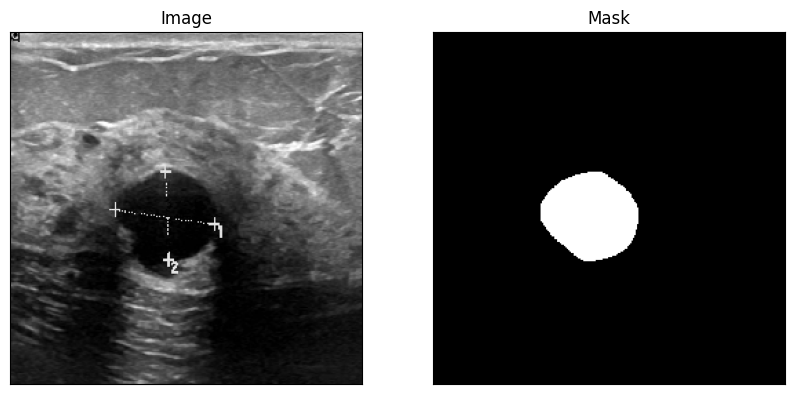

In [ ]:
img_num = random.randint(0, dataset.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

### Creating Datasets for Training and Validation ###

In [ ]:
# sam_dataset = dataset.remove_columns(["id", "label"])
# sam_dataset = sam_dataset.rename_column("mask", "label")

In [19]:
splits = dataset.train_test_split(test_size=0.05, shuffle=True)
splits

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 614
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 33
    })
})

In [20]:
# split up training into training + test
train_ds = splits['train']
test_ds = splits['test']

# MODEL 2: MedSAM

### Sam Dataset ###

In [27]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [28]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]

    ground_truth_mask = np.array(item["label"])
    ground_truth_mask = (ground_truth_mask / 255).astype('int32')
    # ground_truth_mask = np.array(item["label"].convert('1')).astype(np.int32)

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor

# processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=train_ds, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

### Load the Model ###

In [ ]:
# Load the model
from transformers import SamModel

# model = SamModel.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("wanglab/medsam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

### Training the Model ###

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 307/307 [02:07<00:00,  2.41it/s]


EPOCH: 0
Mean loss: 0.14124633032064096


100%|██████████| 307/307 [02:01<00:00,  2.54it/s]


EPOCH: 1
Mean loss: 0.12473407535774311


100%|██████████| 307/307 [02:00<00:00,  2.54it/s]


EPOCH: 2
Mean loss: 0.12028043981677934


100%|██████████| 307/307 [02:00<00:00,  2.54it/s]


EPOCH: 3
Mean loss: 0.11396615697428925


100%|██████████| 307/307 [02:01<00:00,  2.52it/s]


EPOCH: 4
Mean loss: 0.1112850258788185


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 5
Mean loss: 0.11101722372665468


100%|██████████| 307/307 [02:02<00:00,  2.51it/s]


EPOCH: 6
Mean loss: 0.10667693062840145


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 7
Mean loss: 0.10253678815566755


100%|██████████| 307/307 [01:59<00:00,  2.56it/s]


EPOCH: 8
Mean loss: 0.1016663817646352


100%|██████████| 307/307 [02:00<00:00,  2.54it/s]


EPOCH: 9
Mean loss: 0.10110622247626416


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 10
Mean loss: 0.09889216619128124


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 11
Mean loss: 0.09567962334482212


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 12
Mean loss: 0.09566760194223944


100%|██████████| 307/307 [01:58<00:00,  2.58it/s]


EPOCH: 13
Mean loss: 0.09335131450565319


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 14
Mean loss: 0.09292903060779122


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 15
Mean loss: 0.09192873472014157


100%|██████████| 307/307 [01:58<00:00,  2.58it/s]


EPOCH: 16
Mean loss: 0.09036231360091837


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 17
Mean loss: 0.0880828624536626


100%|██████████| 307/307 [01:59<00:00,  2.56it/s]


EPOCH: 18
Mean loss: 0.08759568429609657


100%|██████████| 307/307 [02:01<00:00,  2.52it/s]


EPOCH: 19
Mean loss: 0.08701782966038692


100%|██████████| 307/307 [02:01<00:00,  2.53it/s]


EPOCH: 20
Mean loss: 0.08396375554853425


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 21
Mean loss: 0.08451094002696513


100%|██████████| 307/307 [01:59<00:00,  2.56it/s]


EPOCH: 22
Mean loss: 0.08195487238126974


100%|██████████| 307/307 [01:59<00:00,  2.58it/s]


EPOCH: 23
Mean loss: 0.08517715607918434


100%|██████████| 307/307 [01:58<00:00,  2.60it/s]


EPOCH: 24
Mean loss: 0.08151310241814545


100%|██████████| 307/307 [01:58<00:00,  2.58it/s]


EPOCH: 25
Mean loss: 0.08062274582344274


100%|██████████| 307/307 [01:59<00:00,  2.57it/s]


EPOCH: 26
Mean loss: 0.0795122755612535


100%|██████████| 307/307 [01:59<00:00,  2.58it/s]


EPOCH: 27
Mean loss: 0.07838213456497324


100%|██████████| 307/307 [02:00<00:00,  2.54it/s]


EPOCH: 28
Mean loss: 0.07867653813540741


100%|██████████| 307/307 [01:59<00:00,  2.57it/s]


EPOCH: 29
Mean loss: 0.07736649344211098


100%|██████████| 307/307 [02:01<00:00,  2.52it/s]


EPOCH: 30
Mean loss: 0.07634835754572762


100%|██████████| 307/307 [02:01<00:00,  2.53it/s]


EPOCH: 31
Mean loss: 0.07598186099859325


100%|██████████| 307/307 [02:04<00:00,  2.47it/s]


EPOCH: 32
Mean loss: 0.07537601040585228


100%|██████████| 307/307 [02:24<00:00,  2.12it/s]


EPOCH: 33
Mean loss: 0.07581424201665755


100%|██████████| 307/307 [02:04<00:00,  2.48it/s]


EPOCH: 34
Mean loss: 0.07336780785640598


100%|██████████| 307/307 [02:01<00:00,  2.53it/s]


EPOCH: 35
Mean loss: 0.07276233479210725


100%|██████████| 307/307 [02:01<00:00,  2.53it/s]


EPOCH: 36
Mean loss: 0.0721425468872638


100%|██████████| 307/307 [02:01<00:00,  2.53it/s]


EPOCH: 37
Mean loss: 0.07187810506829416


100%|██████████| 307/307 [02:01<00:00,  2.52it/s]


EPOCH: 38
Mean loss: 0.07414748678014216


100%|██████████| 307/307 [02:00<00:00,  2.54it/s]


EPOCH: 39
Mean loss: 0.07241075067911358


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 40
Mean loss: 0.07061188510870894


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 41
Mean loss: 0.06976544278209683


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 42
Mean loss: 0.06856806556230065


100%|██████████| 307/307 [02:01<00:00,  2.53it/s]


EPOCH: 43
Mean loss: 0.06881976429773465


100%|██████████| 307/307 [02:00<00:00,  2.56it/s]


EPOCH: 44
Mean loss: 0.06752572291764258


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


EPOCH: 45
Mean loss: 0.06843197791676374


100%|██████████| 307/307 [02:00<00:00,  2.54it/s]


EPOCH: 46
Mean loss: 0.0671801372622337


100%|██████████| 307/307 [01:59<00:00,  2.56it/s]


EPOCH: 47
Mean loss: 0.06632981551295383


100%|██████████| 307/307 [01:59<00:00,  2.56it/s]


EPOCH: 48
Mean loss: 0.06637452052548187


100%|██████████| 307/307 [02:03<00:00,  2.48it/s]

EPOCH: 49
Mean loss: 0.06476433046089322


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/CS677 Project - ZTB/medsam_model_checkpoint.pth")

### Inference ###

In [22]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [23]:
# Load the model configuration
# model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
model_config = SamConfig.from_pretrained("wanglab/medsam-vit-base")

# processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")

# Create an instance of the model architecture with the loaded configuration
model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
model.load_state_dict(torch.load("/content/drive/MyDrive/BreastCancerDiagnosis/medsam_model_checkpoint.pth"))

config.json:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

<All keys matched successfully>

In [24]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [25]:
def compute_dice(mask_gt, mask_pred):
    """Compute soerensen-dice coefficient.
    Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN
    """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    if volume_sum == 0:
        return np.NaN
    volume_intersect = (mask_gt & mask_pred).sum()
    return 2*volume_intersect / volume_sum

  0%|          | 0/33 [00:00<?, ?it/s]

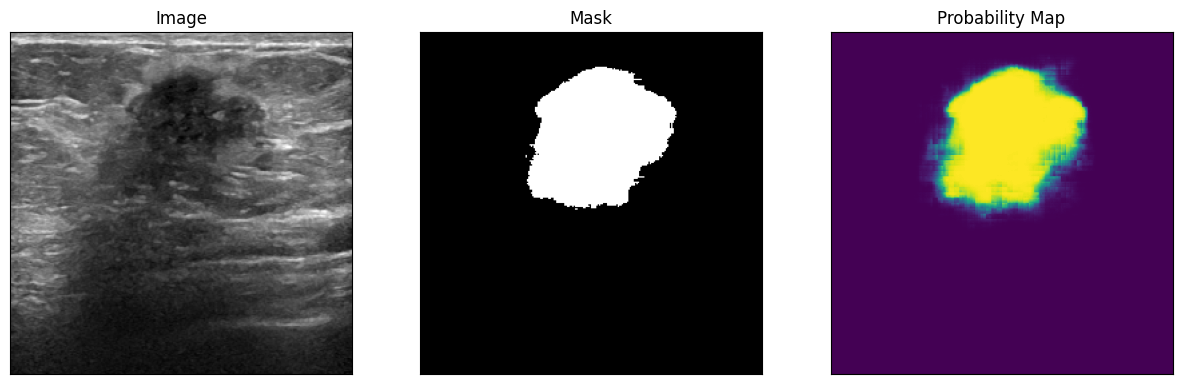

  3%|▎         | 1/33 [00:00<00:22,  1.39it/s]

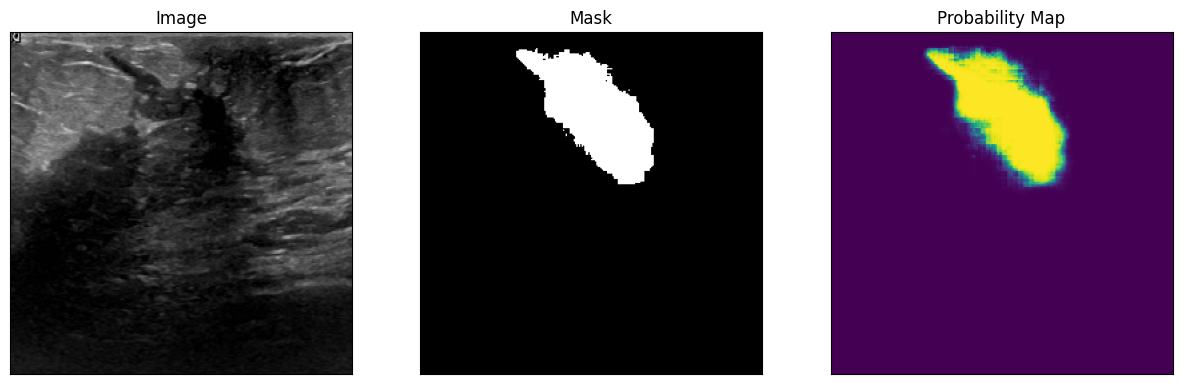

  6%|▌         | 2/33 [00:01<00:22,  1.38it/s]

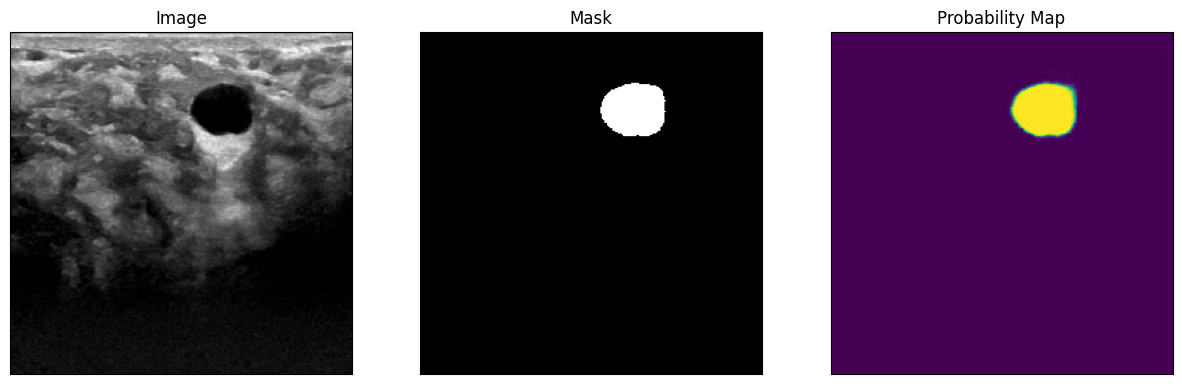

  9%|▉         | 3/33 [00:02<00:21,  1.40it/s]

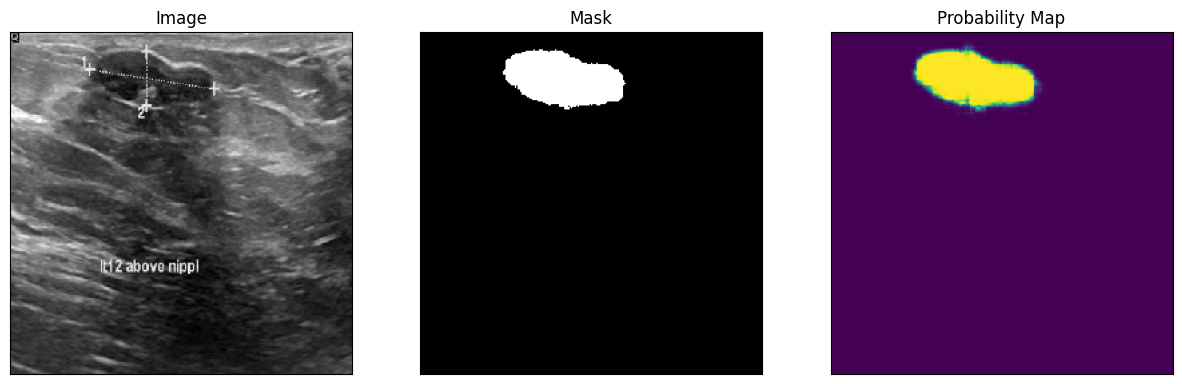

 12%|█▏        | 4/33 [00:03<00:27,  1.04it/s]

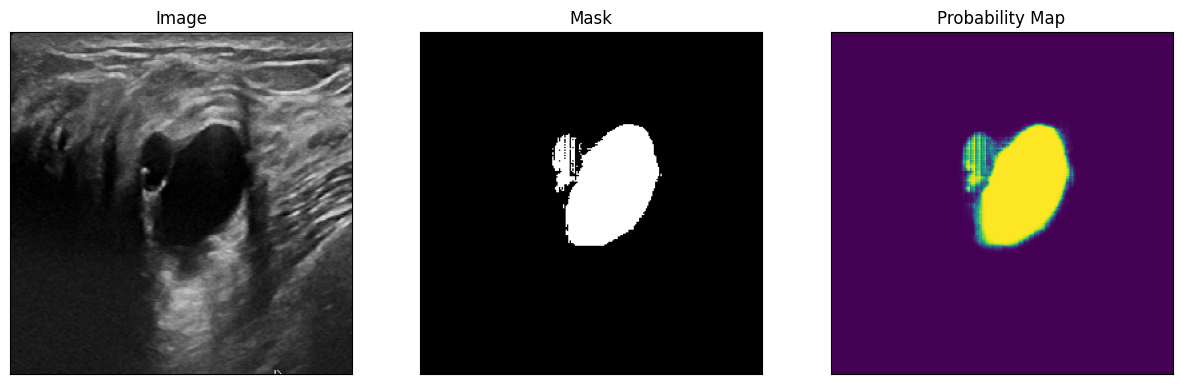

 15%|█▌        | 5/33 [00:04<00:29,  1.04s/it]

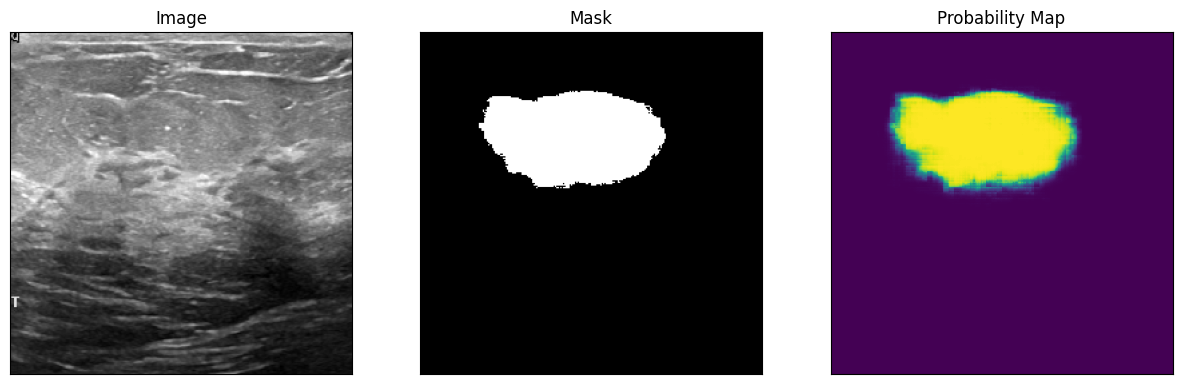

 18%|█▊        | 6/33 [00:05<00:27,  1.03s/it]

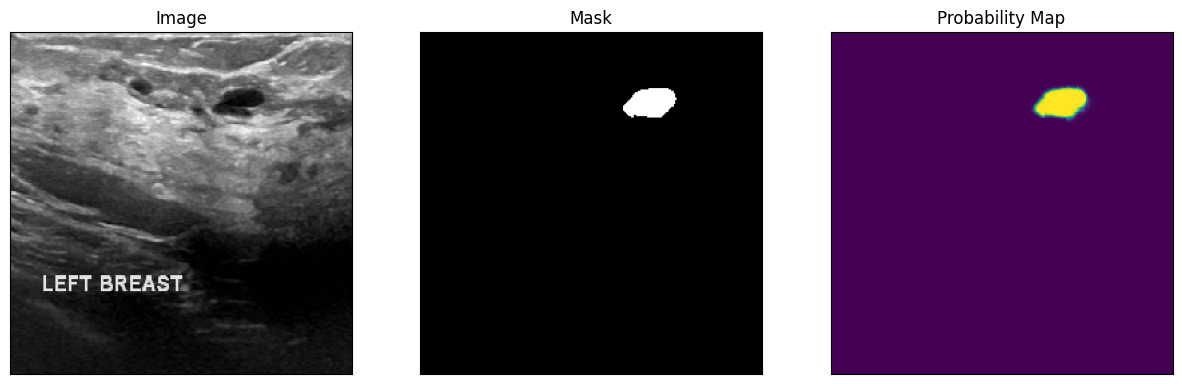

 21%|██        | 7/33 [00:06<00:27,  1.07s/it]

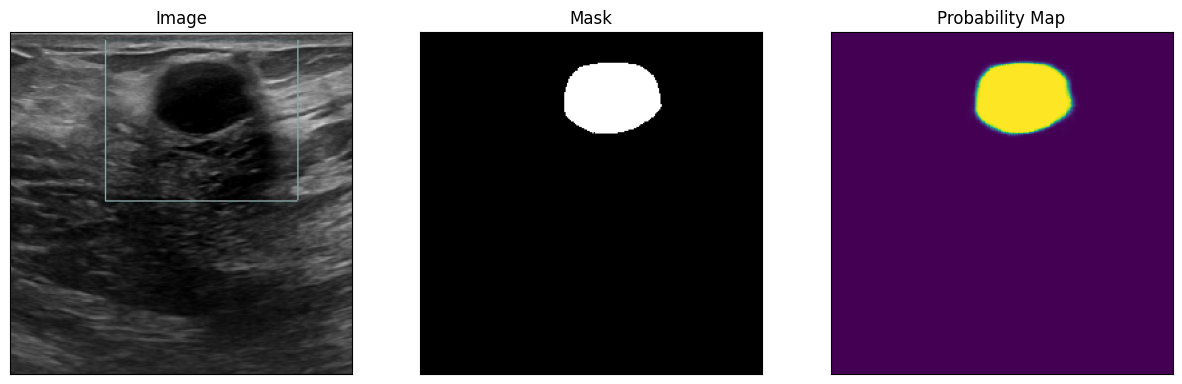

 24%|██▍       | 8/33 [00:07<00:26,  1.04s/it]

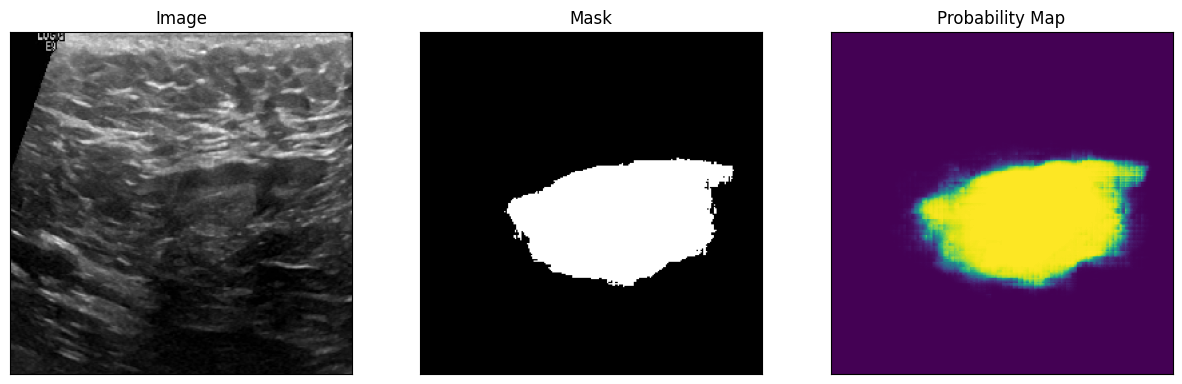

 27%|██▋       | 9/33 [00:09<00:26,  1.10s/it]

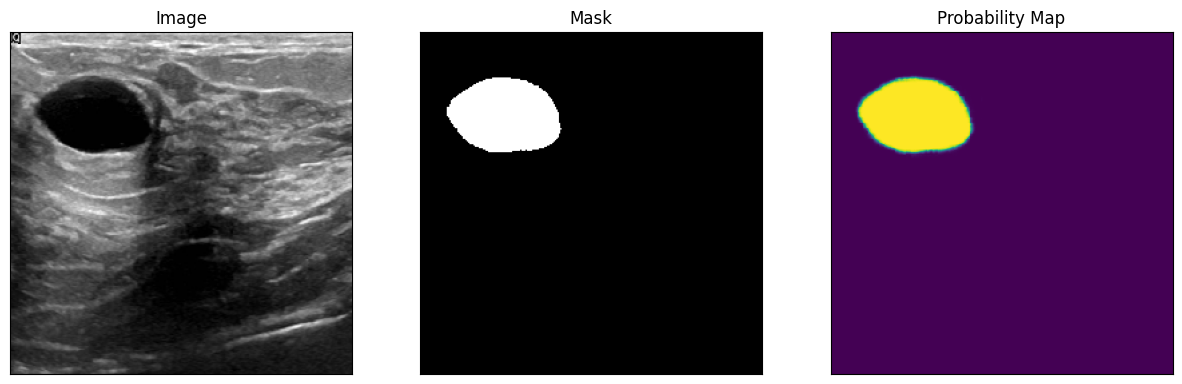

 30%|███       | 10/33 [00:10<00:27,  1.19s/it]

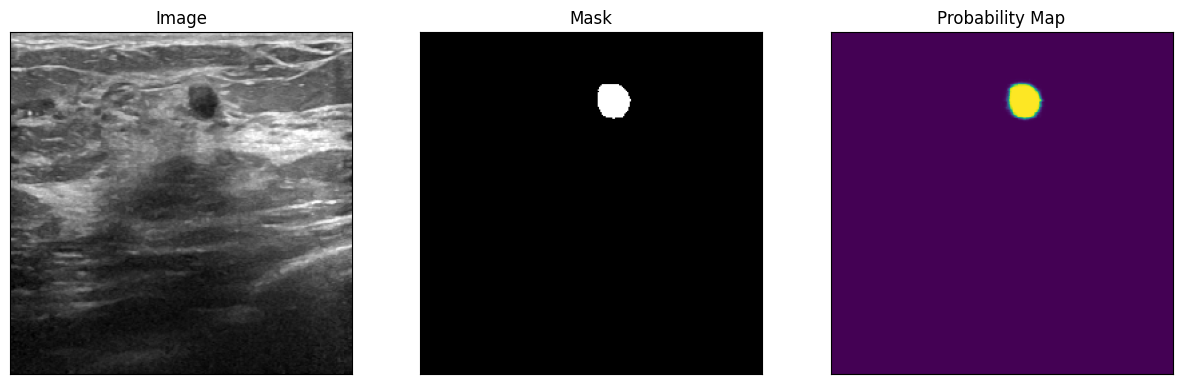

 33%|███▎      | 11/33 [00:11<00:22,  1.01s/it]

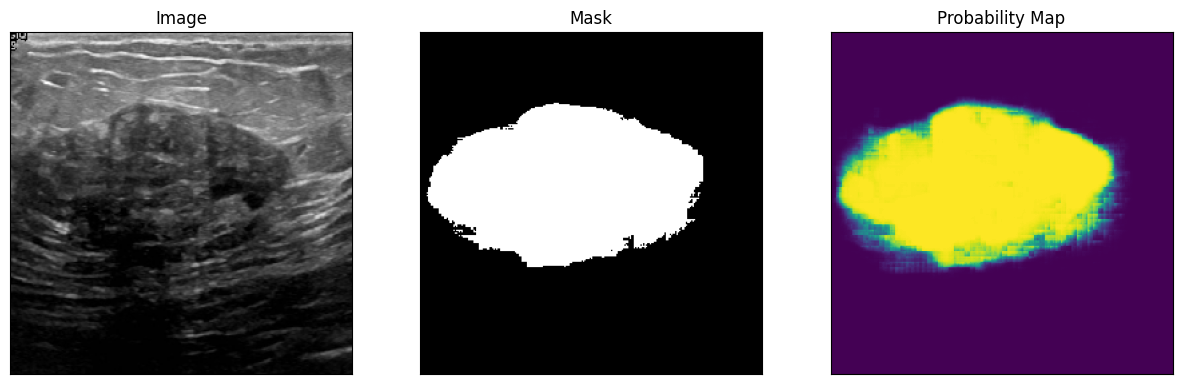

 36%|███▋      | 12/33 [00:11<00:18,  1.16it/s]

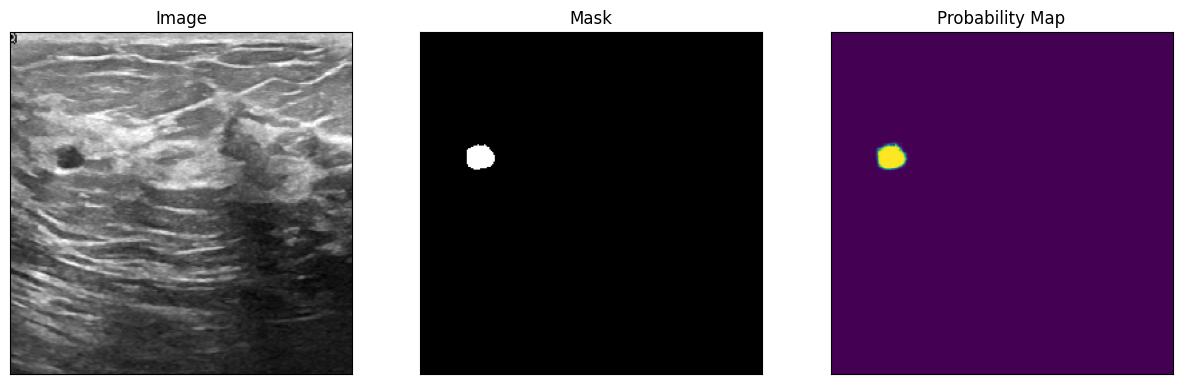

 39%|███▉      | 13/33 [00:12<00:14,  1.34it/s]

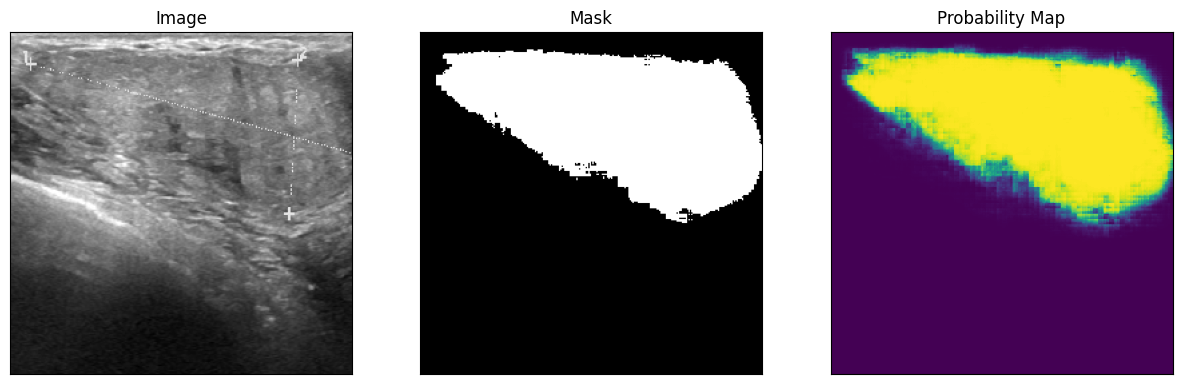

 42%|████▏     | 14/33 [00:12<00:12,  1.48it/s]

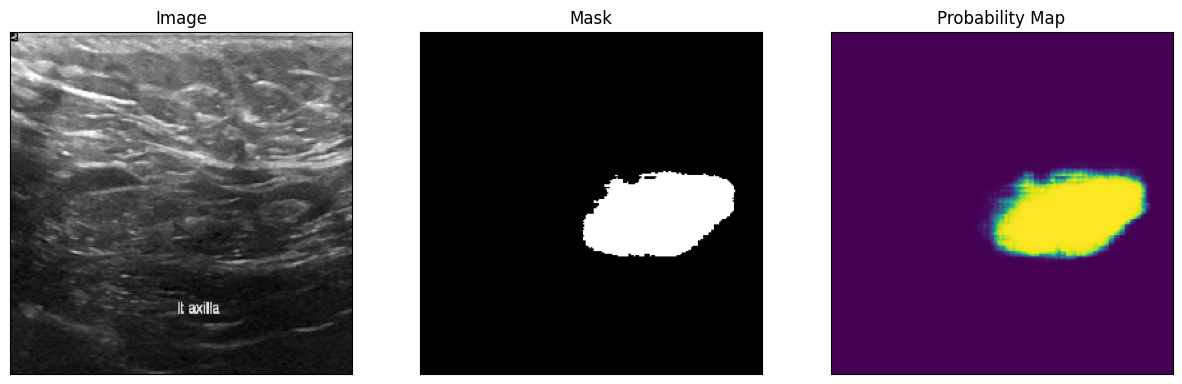

 45%|████▌     | 15/33 [00:13<00:11,  1.62it/s]

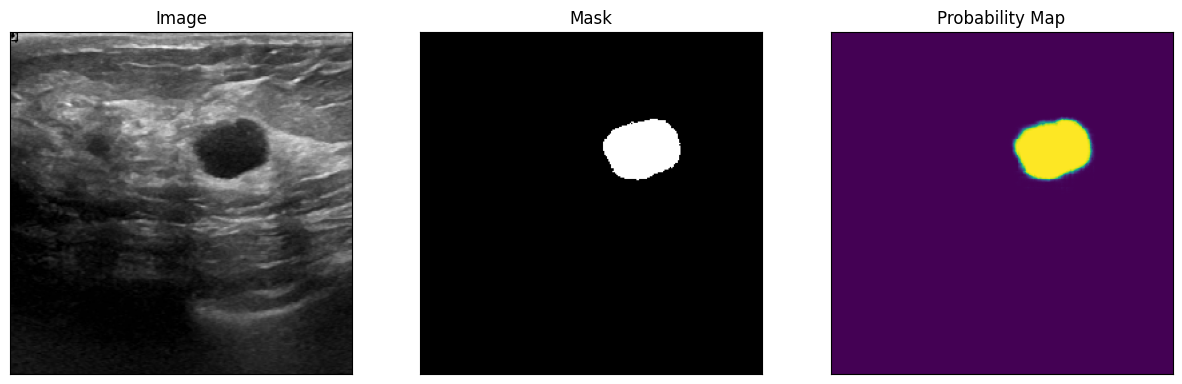

 48%|████▊     | 16/33 [00:13<00:10,  1.68it/s]

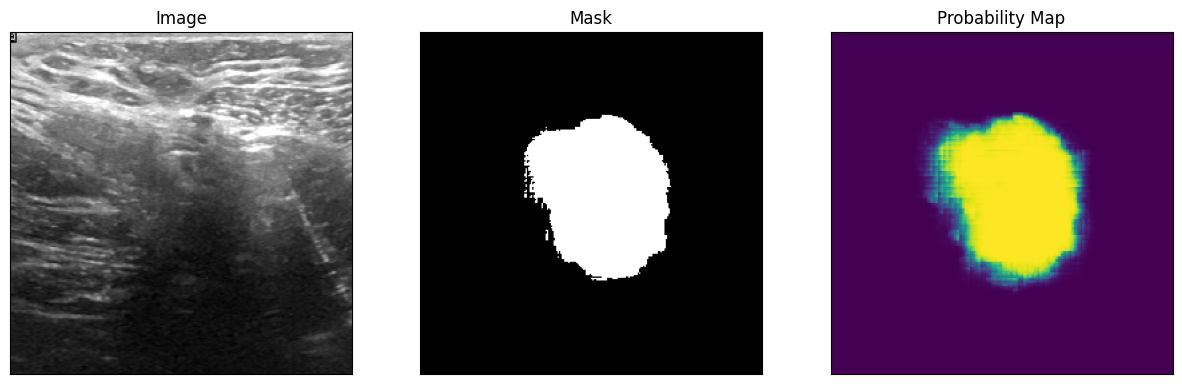

 52%|█████▏    | 17/33 [00:14<00:09,  1.75it/s]

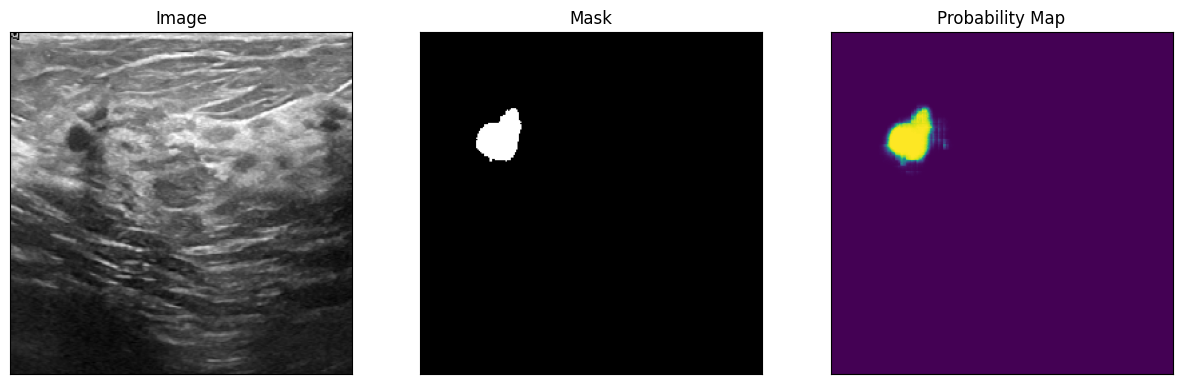

 55%|█████▍    | 18/33 [00:14<00:08,  1.81it/s]

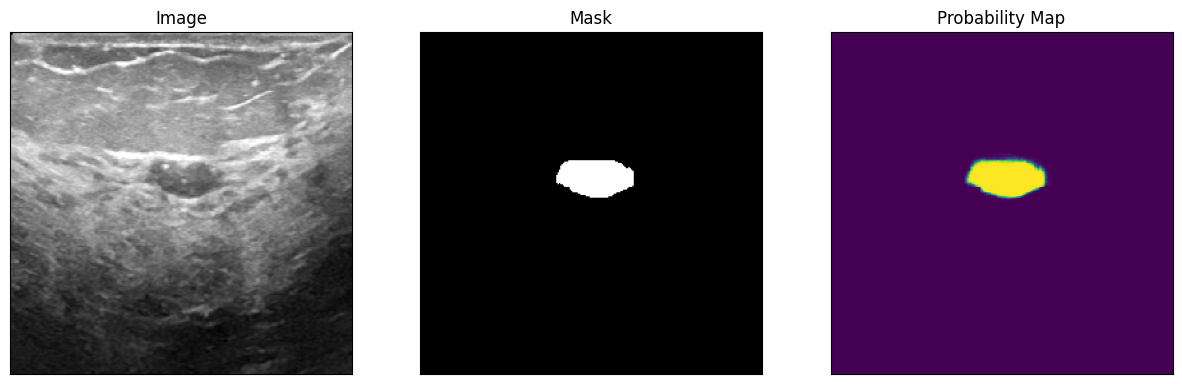

 58%|█████▊    | 19/33 [00:15<00:07,  1.87it/s]

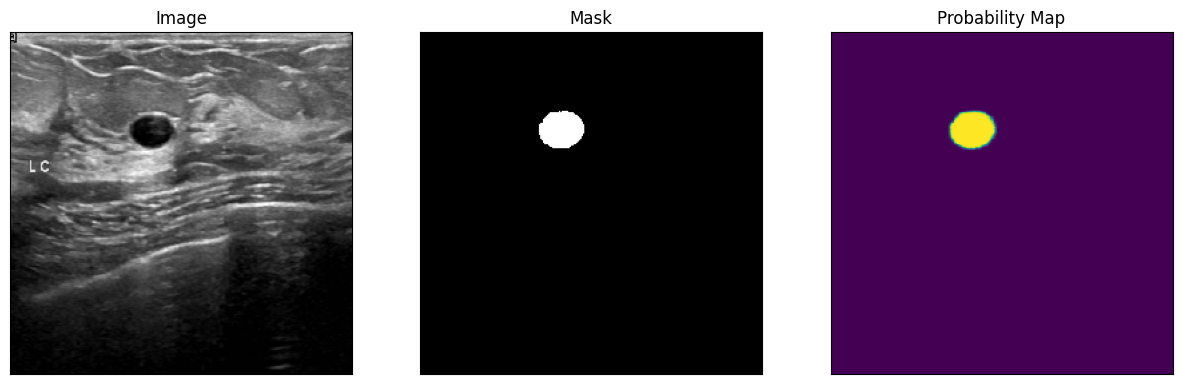

 61%|██████    | 20/33 [00:15<00:06,  1.91it/s]

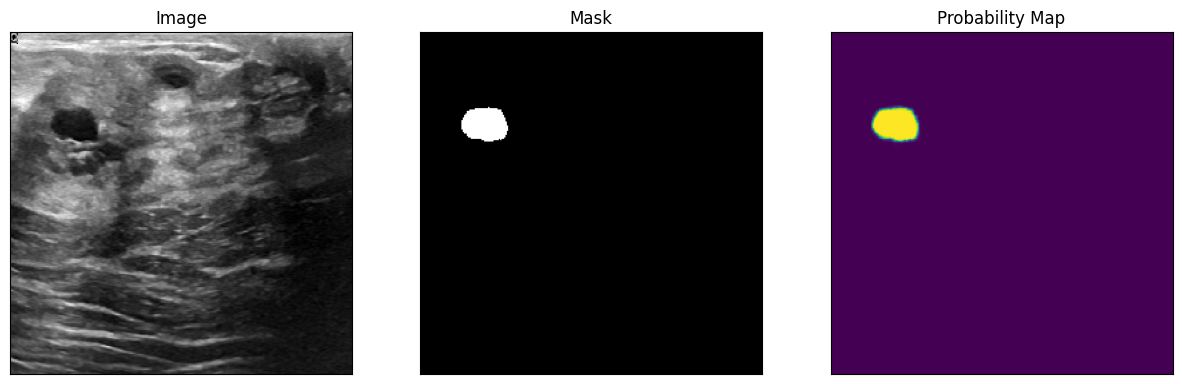

 64%|██████▎   | 21/33 [00:16<00:06,  1.96it/s]

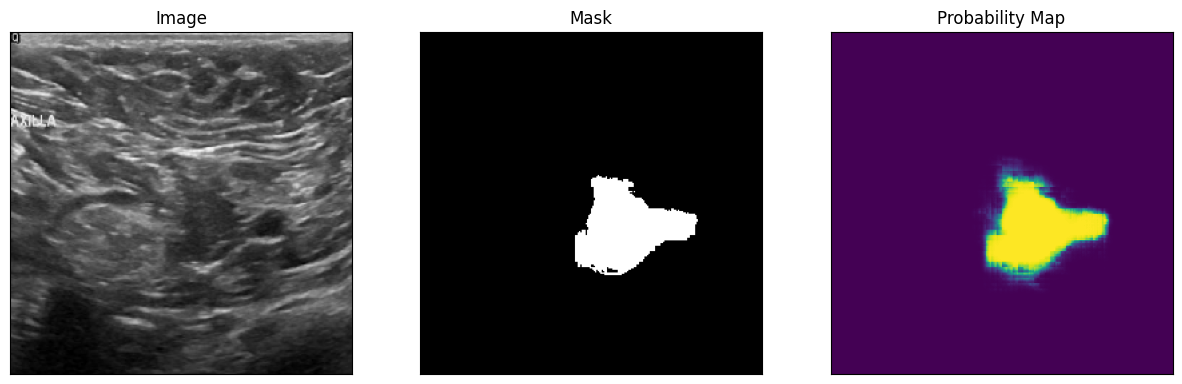

 67%|██████▋   | 22/33 [00:16<00:05,  1.97it/s]

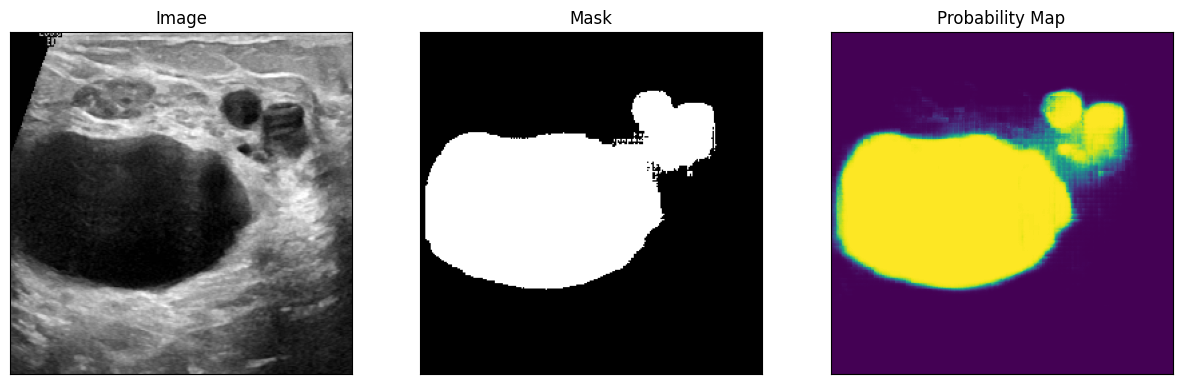

 70%|██████▉   | 23/33 [00:17<00:05,  1.98it/s]

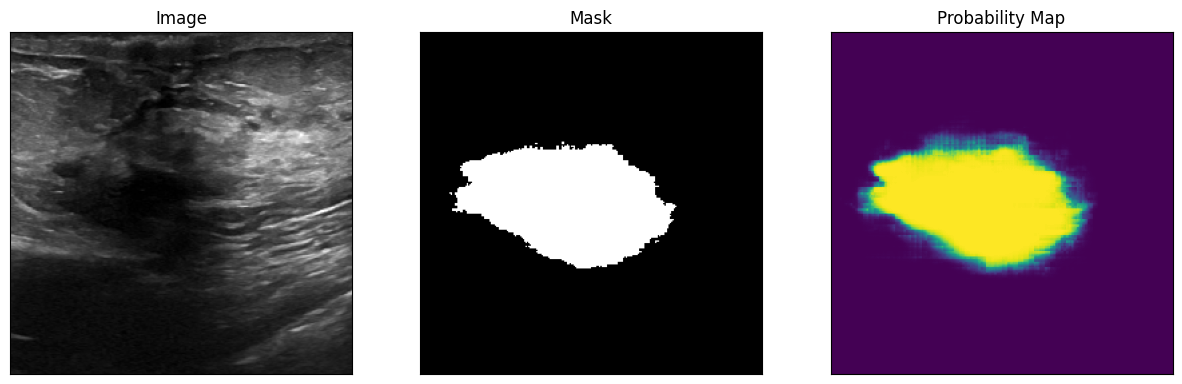

 73%|███████▎  | 24/33 [00:17<00:04,  1.99it/s]

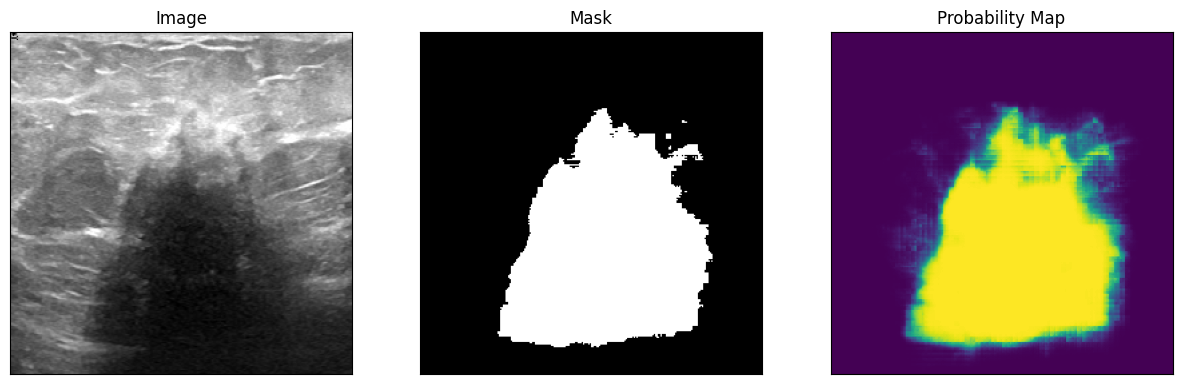

 76%|███████▌  | 25/33 [00:18<00:03,  2.01it/s]

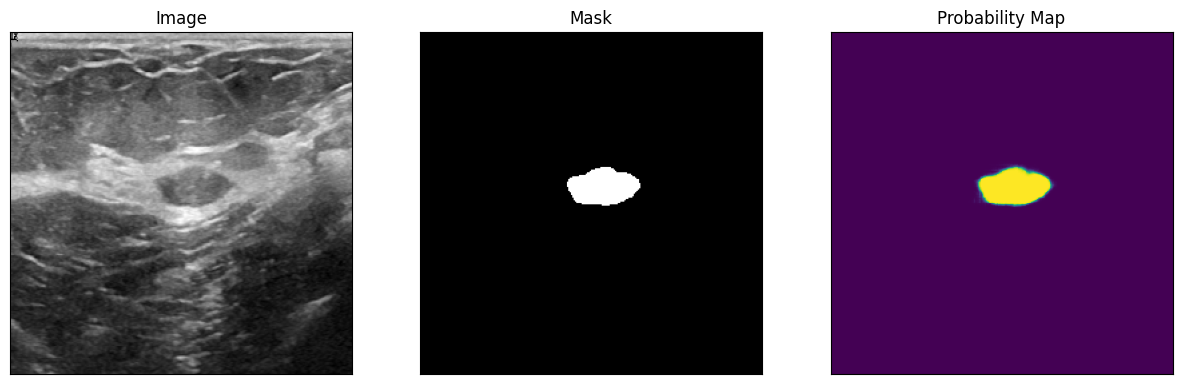

 79%|███████▉  | 26/33 [00:18<00:03,  2.00it/s]

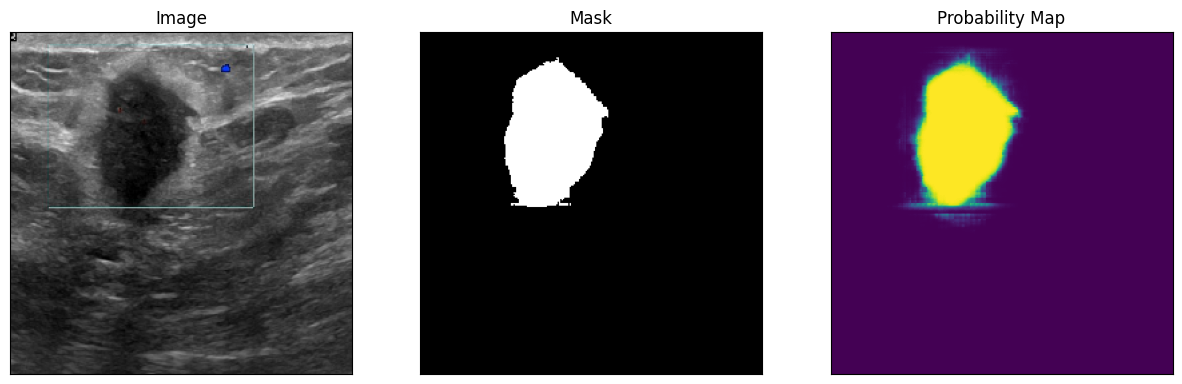

 82%|████████▏ | 27/33 [00:19<00:02,  2.01it/s]

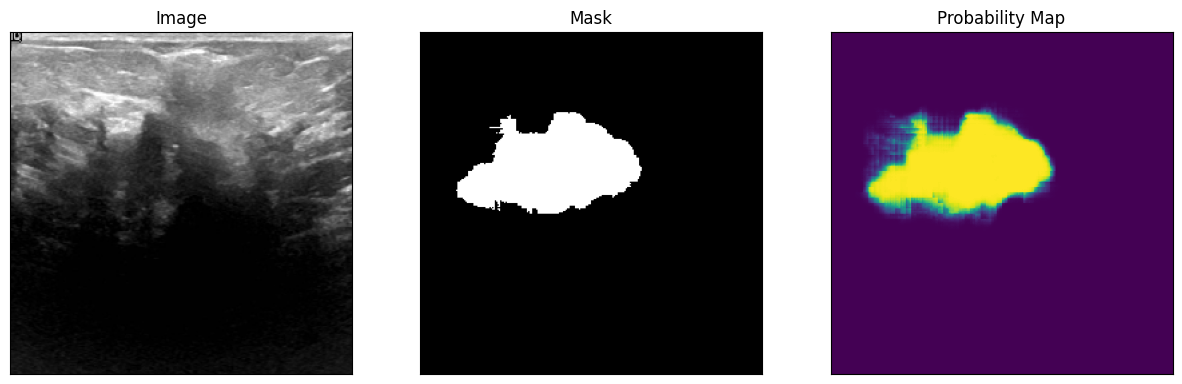

 85%|████████▍ | 28/33 [00:19<00:02,  2.01it/s]

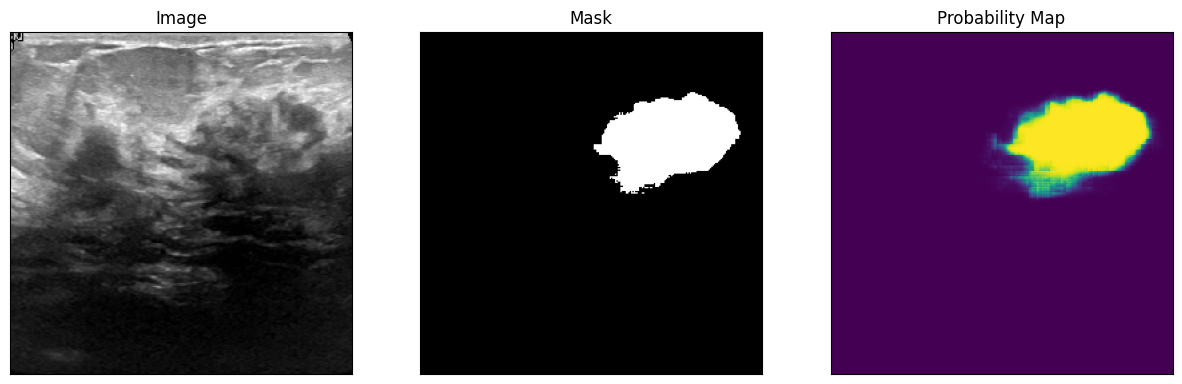

 88%|████████▊ | 29/33 [00:20<00:01,  2.02it/s]

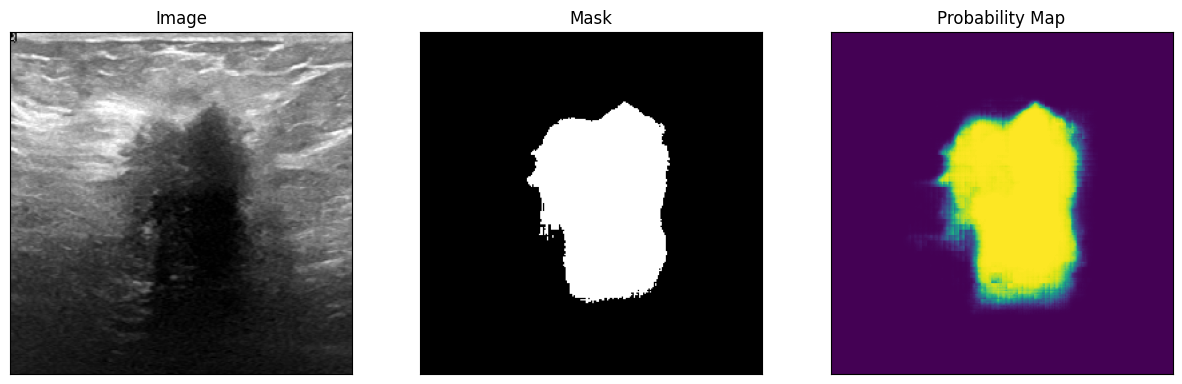

 91%|█████████ | 30/33 [00:20<00:01,  1.98it/s]

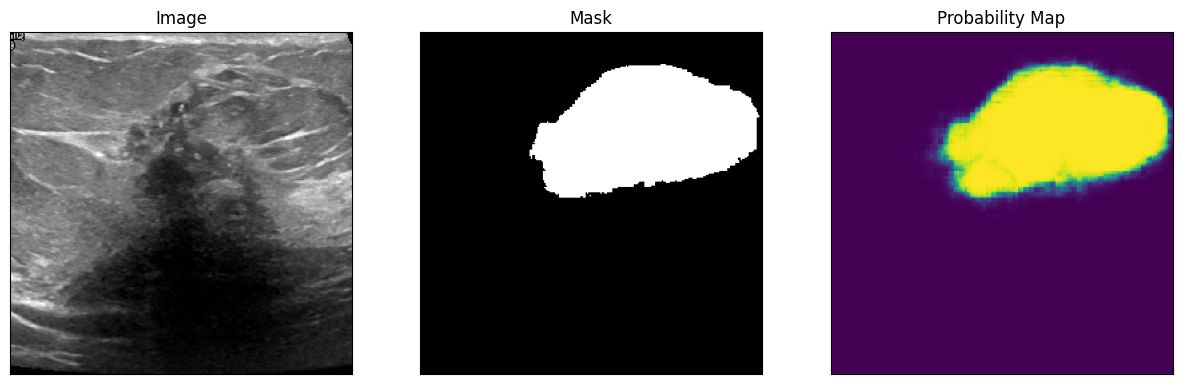

 94%|█████████▍| 31/33 [00:21<00:01,  1.95it/s]

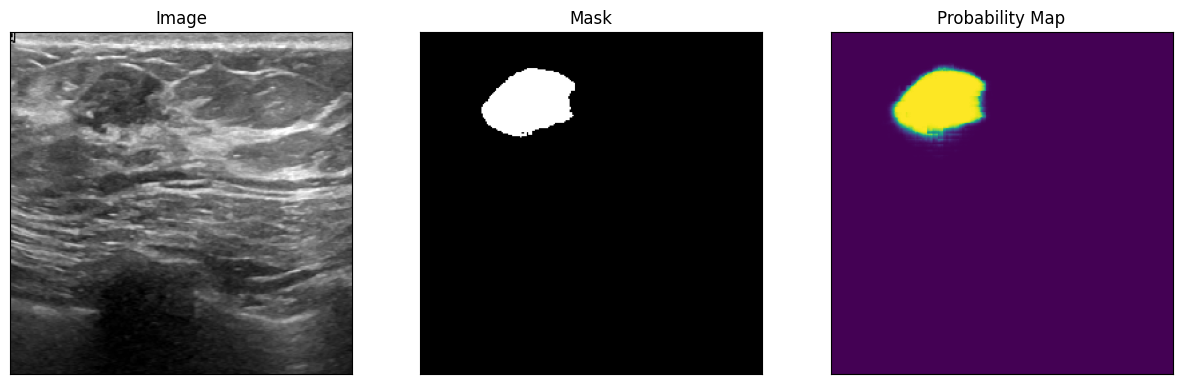

 97%|█████████▋| 32/33 [00:22<00:00,  1.45it/s]

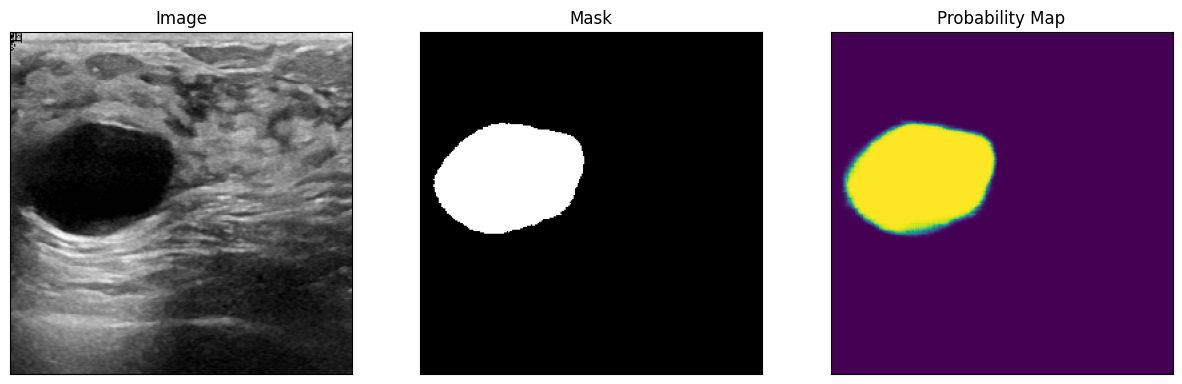

100%|██████████| 33/33 [00:22<00:00,  1.44it/s]

EPOCH: 0
Sam Dice Scores: 0.9416171087060545


In [31]:
from tqdm import tqdm
from statistics import mean

num_epochs = 1

for epoch in range(num_epochs):
    sam_dice_scores = []
    for row in tqdm(test_ds):
        # let's take a random training example
        idx = random.randint(0, test_ds.shape[0]-1)
        # load image
        test_image = row["image"]
        # get box prompt based on ground truth segmentation map
        ground_truth_mask = np.array(row["label"])
        ground_truth_mask = (ground_truth_mask / 255).astype('int32')
        prompt = get_bounding_box(ground_truth_mask)
        # prepare image + box prompt for the model
        inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
        # Move the input tensor to the GPU if it's not already there
        inputs = {k: v.to(device) for k, v in inputs.items()}


        model.eval()

        # forward pass
        with torch.no_grad():
            outputs = model(**inputs, multimask_output=False)
        # apply sigmoid
        medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        sam_dice_scores.append(compute_dice(ground_truth_mask, medsam_seg))

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        # Plot the first image on the left
        axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
        axes[0].set_title("Image")
        # Plot the second image on the right
        axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
        axes[1].set_title("Mask")
        # Plot the second image on the right
        axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
        axes[2].set_title("Probability Map")
        # Hide axis ticks and labels
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        # Display the images side by side
        plt.show()
    print(f'EPOCH: {epoch}')
    print(f'Sam Dice Scores: {mean(sam_dice_scores)}')